In [1]:
import os
import json
import pandas as pd
import matplotlib
from matplotlib import rc
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from datetime import datetime as dt
from scipy.stats import chi2,f, bartlett, levene

In [2]:
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

# Load Data

In [67]:
DATASET = 'winogrande-m-option'
wd = os.path.dirname(os.path.abspath('__file__'))
f_name1 = f"{DATASET}_1.csv"
f_name2 = f"{DATASET}_2.csv"
f_namequad = f"{DATASET}_quad.csv"
f_namequadpair = f"{DATASET}_quad-pair.csv"

results1 = pd.read_csv(os.path.join(wd, f_name1))
results2 = pd.read_csv(os.path.join(wd, f_name2))
results3 = pd.read_csv(os.path.join(wd, f_namequad))
results4 = pd.read_csv(os.path.join(wd, f_namequadpair)).reset_index()


results = pd.concat([results1,results2,results3]).reset_index()
results = results.loc[results['dataset']==DATASET,:]
results4 = results4.loc[results4['dataset']==DATASET,:]

In [4]:
print(results)
print(results['best_val_accuracy'])

     index              dataset            framing  learning_rate  batch_size  \
121    121  winogrande-m-option             MC-MLM        0.00001          16   
122    122  winogrande-m-option             MC-MLM        0.00001          16   
123    123  winogrande-m-option             MC-MLM        0.00001          64   
124    124  winogrande-m-option             MC-MLM        0.00002          32   
125    125  winogrande-m-option             MC-MLM        0.00002          32   
..     ...                  ...                ...            ...         ...   
596     55  winogrande-m-option  MC-SENT-PAIR-QUAD        0.00002          64   
597     56  winogrande-m-option  MC-SENT-PAIR-QUAD        0.00003          16   
598     57  winogrande-m-option  MC-SENT-PAIR-QUAD        0.00003          16   
599     58  winogrande-m-option  MC-SENT-PAIR-QUAD        0.00003          16   
600     59  winogrande-m-option  MC-SENT-PAIR-QUAD        0.00003          16   

     max_epochs    seed  be

In [5]:
print(len(results['exp_name'].unique()))

480


In [6]:
print(results.loc[results['framing']=='MC-SENT-PAIR-QUAD'].shape)

(60, 13)


# Analyze

In [7]:
def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value

In [60]:
def make_box_plots(data,
                   labels,
                   experiment_labels, 
                   key_frame = 'framing',
                   key_acc = 'best_val_accuracy',
                   x_size = 15,
                   y_size = 5,
                   y_min = 55,
                   y_max = 100,
                   y_tick = 15,
                   y_offset = 1,
                   x_offset = .85,
                   splines_offset = 10,
                   bar_trans = 0.3,
                   colors = ['darkgrey',
                             'peachpuff',
                             'burlywood',
                             'gold',
                             'lightgreen',
                             'skyblue',
                             'plum',
                             'darkgrey'
                            ],
                   bar_colors = True,
                   bar_labels = True,
                   adjusted_axes = True,
                   title = None,
                   showfliers = True,
                   notch = False,
                   majority = None,
                   human = None,
                   ylabel = 'Accuracy (%)',
                   xlabel = 'Formalization',
                   label_size = 18,
                   tick_size = 12,
                   plabel_size = 12,
                   bar = False,
                   label_type = 'max',
                   box = True,
                   violin = False,
                   titlepad=None,
                   titleh=None,
                  ):    
    scores = {
        'all'    : [],
        'max'    : [],
        '3Q'     : [],
        'median' : [],
    }
    
    add_x_offset = {
        'max'    : 0,
        '3Q'     : 0.4,
        'median' : 0.45,
    }
    
    add_y_offset = {
        'max'    : 0,
        '3Q'     : -y_offset,
        'median' : -y_offset,
    }  
        
    for label in experiment_labels:
        dist = data.loc[data[key_frame]==label,key_acc]*100
        scores['all'].append(sorted(dist.to_numpy()))
        scores['max'].append(max(dist))
        scores['3Q'].append(dist.quantile(q=0.75))
        scores['median'].append(dist.median())
    
    n_samples = len(scores['all'][0])
    
    # add majority class
    if not majority is None:
        labels.insert(0,'Majority')
        if bar:
            scores['all'].insert(0,[0])
        else:
            scores['all'].insert(0,[majority]*n_samples)
        
        for key, item in scores.items():
            if key != 'all':
                item.insert(0,majority)
    
    # add human results
    if not human is None:
        labels.append('Human')
        if bar:
            scores['all'].append([0])
        else:
            scores['all'].append([human]*n_samples)

        for key, item in scores.items():
            if key != 'all':
                item.append(human)
    
    
    # create figure
    fig, ax = plt.subplots(figsize=(x_size, y_size))
    
    # format chart
    if not title is None:
#         ax.set_title(title, fontsize=label_size, pad=titlepad)
        ax.text(len(labels)/2+0.5,
                titleh,
                title,
                fontsize=label_size,
                ha="center",
                )
    
    # format labels
    ax.set_ylim(y_min, y_max)
    ax.set_yticks(np.arange(y_min, y_max+1, y_tick))
    ax.set_xticklabels(labels)
    ax.tick_params(labelsize=tick_size)
    
    if adjusted_axes:
        # Adjust plot borders
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_position(('outward', splines_offset))
        ax.spines['bottom'].set_position(('outward', splines_offset))
    
    ticks = np.arange(len(labels))+1
    
    ax.set_ylabel(ylabel, fontsize=label_size)
    ax.set_xlabel(xlabel, fontsize=label_size)
    
    # make plots    
    assert label_type in scores.keys(), f"label_type {label_type} not supported"
    
    if bar:
        # bar chart
        if not bar_colors:
            colors = None
        ax.bar(ticks, scores[label_type], color = colors, alpha=bar_trans)
        
    if box:
        # box plot
        ax.boxplot(scores['all'], notch = notch, showfliers = showfliers)
        
    if violin:
        # violin plot
        ax.set_xticks(ticks)
        
        parts = ax.violinplot(scores['all'], positions = ticks, showmedians = False, showextrema=False, bw_method='silverman')
        
        if bar_colors:
            for pc, color in zip(parts['bodies'], colors):
                pc.set_facecolor(color)
                pc.set_alpha(.5)
                pc.set_edgecolor('black')
        
        print(type(scores['all']))
        quartile1, medians, quartile3 = np.percentile(np.array(scores['all']).reshape(len(scores['all']),-1), [25, 50, 75], axis=1)
        whiskers = np.array([
            adjacent_values(sorted_array, q1, q3)
            for sorted_array, q1, q3 in zip(scores['all'], quartile1, quartile3)])
        whiskersMin, whiskersMax = whiskers[:, 0], whiskers[:, 1]

        inds = np.arange(1, len(medians) + 1)
        ax.scatter(inds[1:len(inds)-1], medians[1:len(inds)-1], marker='_', color='orange', s=1000, zorder=3)
        ax.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
        ax.vlines(inds, whiskersMin, whiskersMax, color='k', linestyle='-', lw=1)
                
    
    # add accuracy values
    for i, v in enumerate(scores[label_type]):
        if bar_labels or (i==0 or i==len(scores[label_type])-1):
            
            x=add_x_offset[label_type]
            y=add_y_offset[label_type]
            
            if ((not human is None and i == len(scores[label_type])-1)
                or (not majority is None and i == 0)):
                x = 0
                y = 0
                
            ax.text(i + x_offset + x,
                    v + y_offset + y,
                    "{:.1f}%".format(v),
                    fontsize=plabel_size,
                   )
    
    # Adjust layout
    fig.tight_layout()
    
    return fig

In [55]:
a = np.array([np.array([1,2,3]),np.array([3,4,3])])

print(a.shape)

a.reshape(-1,1)

print(a.shape)

(2, 3)
(2, 3)


<class 'list'>


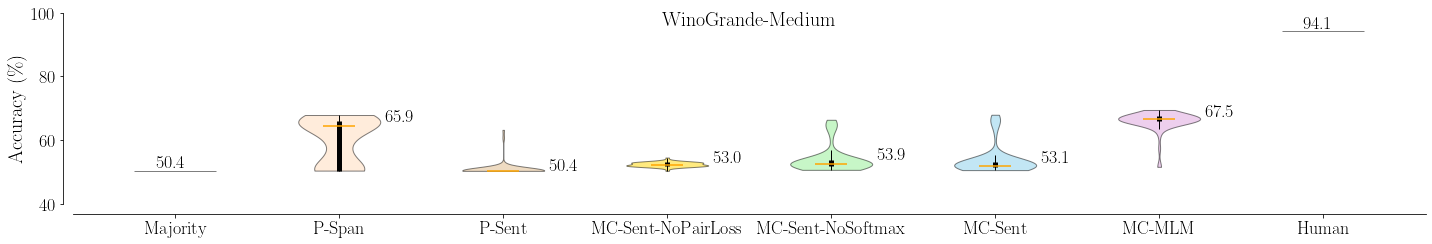

In [61]:
bar = False
box = False
violin = True

ordered_framings = ['P-SPAN',
                   'P-SENT',
                   'MC-SENT-PLOSS',
                   'MC-SENT-PAIR',
                   'MC-SENT',
                   'MC-MLM']

chart_labels = ['P-Span',
               'P-Sent',
               'MC-Sent-NoPairLoss',
               'MC-Sent-NoSoftmax',
               'MC-Sent',
               'MC-MLM']

f_violin = make_box_plots(results,
                   chart_labels,
                   ordered_framings,
                   adjusted_axes = True,
                   title = 'WinoGrande-Medium',
                   titleh=96,
                   showfliers = True,
                   x_size = 20,
                   y_size = 3.5,
                   y_min = 40,
                   y_max = 100,
                   y_tick = 20,
                   notch = False,
                   ylabel = r'Accuracy (\%)',
                   xlabel = None,
                   #xlabel = r'Formalization',
                   majority = 50.43,
                   human = 94.1,
                   label_size=20,
                   tick_size=18,
                   plabel_size=18,
                   x_offset = .88,
                   bar_colors = True,
                   bar_labels = True,
                   label_type = '3Q',
                   bar = bar,
                   box = box,
                   violin = violin,
                  )

<class 'list'>


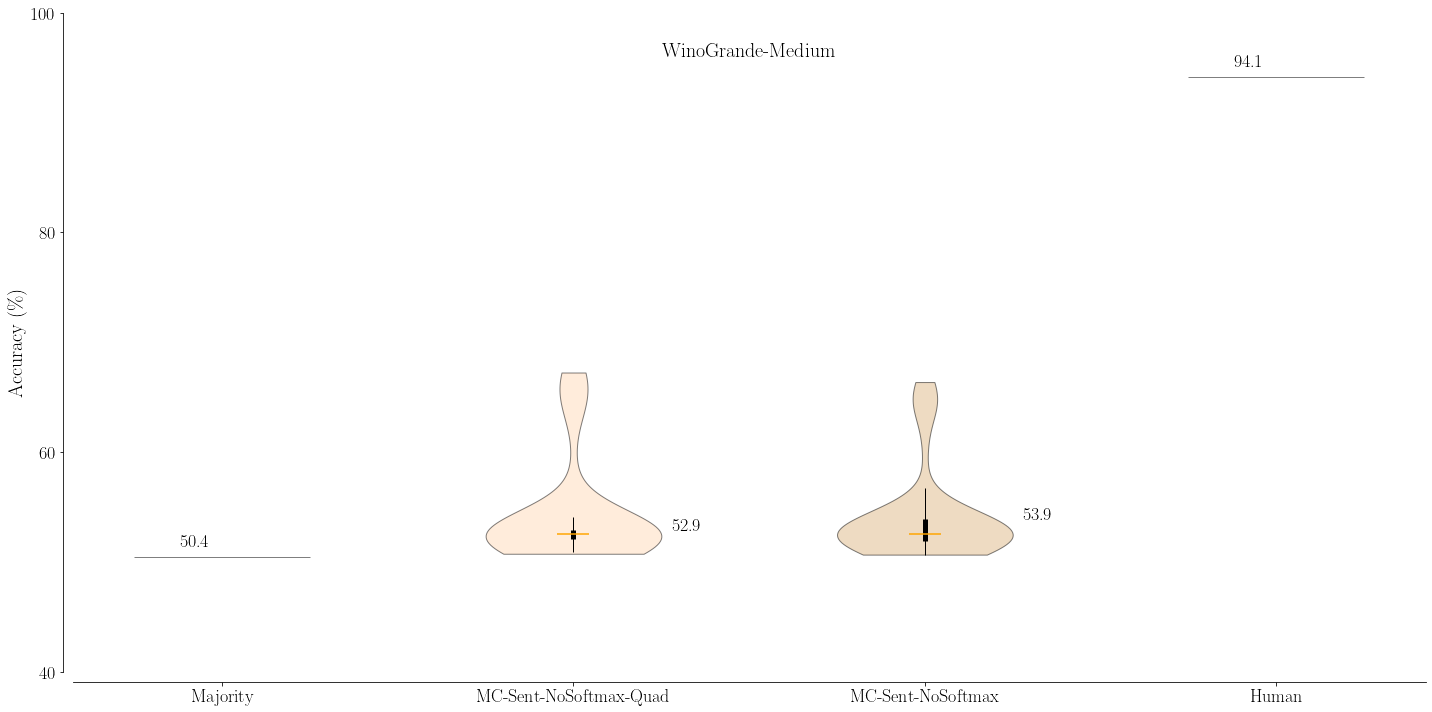

In [62]:
bar = False
box = False
violin = True

ordered_framings = [
    'MC-SENT-PAIR-QUAD',
    'MC-SENT-PAIR',
]

chart_labels = [
    'MC-Sent-NoSoftmax-Quad',
    'MC-Sent-NoSoftmax',
]

f_violin = make_box_plots(results,
                   chart_labels,
                   ordered_framings,
                   adjusted_axes = True,
                   title = 'WinoGrande-Medium',
                   titleh=96,
                   showfliers = True,
                   x_size = 20,
                   y_size = 10,
                   y_min = 40,
                   y_max = 100,
                   y_tick = 20,
                   notch = False,
                   ylabel = r'Accuracy (\%)',
                   xlabel = None,
                   #xlabel = r'Formalization',
                   majority = 50.43,
                   human = 94.1,
                   label_size=20,
                   tick_size=18,
                   plabel_size=18,
                   x_offset = .88,
                   bar_colors = True,
                   bar_labels = True,
                   label_type = '3Q',
                   bar = bar,
                   box = box,
                   violin = violin,
                  )

In [11]:
def get_stats(data,
              labels,
              key_frame = 'framing',
              key_acc = 'best_val_accuracy',
             ):
    results = {label : {} for label in labels}
    
    for label, value in results.items():
        dist = data.loc[data[key_frame]==label,key_acc]
        
        value['mean'] = dist.mean()
        value['std'] = dist.std()
        value['medium'] = dist.median()
        value['1Q'] = dist.quantile(q=0.25)
        value['3Q'] = dist.quantile(q=0.75)
        value['max'] = max(dist)
        value['min'] = min(dist)
        value['top_3Q_dist'] = max(dist)-dist.quantile(q=0.75)
        value['kurtosis'] = dist.kurtosis()
    
    return results

In [12]:
ordered_framings = [
    'P-SPAN',
    'P-SENT',
    'MC-SENT-PLOSS',
    'MC-SENT-PAIR-QUAD',
    'MC-SENT-PAIR',
    'MC-SENT',
    'MC-MLM'
]

stats = get_stats(results,
                  ordered_framings,
                 )

print(stats)

{'P-SPAN': {'mean': 0.6010523546557619, 'std': 0.07029034616035999, 'medium': 0.6432517758955049, '1Q': 0.5043409629280208, '3Q': 0.6592344120380064, 'max': 0.6787687451141315, 'min': 0.5043409629, 'top_3Q_dist': 0.019534333076125177, 'kurtosis': -1.615641100770949}, 'P-SENT': {'mean': 0.5090370955090537, 'std': 0.021061960206107552, 'medium': 0.5043409629280208, '1Q': 0.5043409629, '3Q': 0.5043409629280208, 'max': 0.6322020521, 'min': 0.5035516969453846, 'top_3Q_dist': 0.12786108917197925, 'kurtosis': 27.55161348189248}, 'MC-SENT-PLOSS': {'mean': 0.5242962378353363, 'std': 0.0071131848072470034, 'medium': 0.5232833464938832, '1Q': 0.5197316495953062, '3Q': 0.5297947908719246, 'max': 0.5453827940251005, 'min': 0.5035516969, 'top_3Q_dist': 0.015588003153175878, 'kurtosis': 0.7239932749745304}, 'MC-SENT-PAIR-QUAD': {'mean': 0.5443304393580637, 'std': 0.048827931156448914, 'medium': 0.5256511444356748, '1Q': 0.5209155485398579, '3Q': 0.5290055248618785, 'max': 0.6724546172059984, 'min': 0

In [13]:
ordered_framings = [
    'MC-SENT-PAIR-QUAD',
    'MC-SENT-PAIR',
]

quad_comp = {key:stats[key] for key in ordered_framings}

quad_comp_df = pd.DataFrame(quad_comp)

print(quad_comp_df)

             MC-SENT-PAIR-QUAD  MC-SENT-PAIR
mean                  0.544330      0.541081
std                   0.048828      0.041939
medium                0.525651      0.525651
1Q                    0.520916      0.519337
3Q                    0.529006      0.538674
max                   0.672455      0.663773
min                   0.507498      0.506709
top_3Q_dist           0.143449      0.125099
kurtosis              2.029027      2.974123


In [66]:
# Perform Levene, Bartlett, and F test:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.levene.html#scipy.stats.levene
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bartlett.html
# https://stackoverflow.com/questions/21494141/how-do-i-do-a-f-test-in-python

mcsentpair = results.loc[results['framing']=='MC-SENT-PAIR']['best_val_accuracy']
mcsentpairquad = results.loc[results['framing']=='MC-SENT-PAIR-QUAD']['best_val_accuracy']

levene_stat, levene_p = levene(mcsentpair, mcsentpairquad)
bartlett_stat, bartlett_p = bartlett(mcsentpair, mcsentpairquad)
f_p = f.cdf(mcsentpairquad.var()/mcsentpair.var(),len(mcsentpairquad)-1,len(mcsentpair)-1)

print("Levene:")
print(f"Stat is: {levene_stat}")
print(f"P-value is: {levene_p}\n")

print("Bartlett:")
print(f"Stat is: {bartlett_stat}")
print(f"P-value is: {bartlett_p}\n")

print("F:")
print(f"P-value is: {f_p}\n")

Levene:
Stat is: 0.12811924166864214
P-value is: 0.7210295766159451

Bartlett:
Stat is: 1.3478336690694532
P-value is: 0.24565719499634936

F:
P-value is: 0.8771691720281415



## Quad Comparison

<class 'list'>


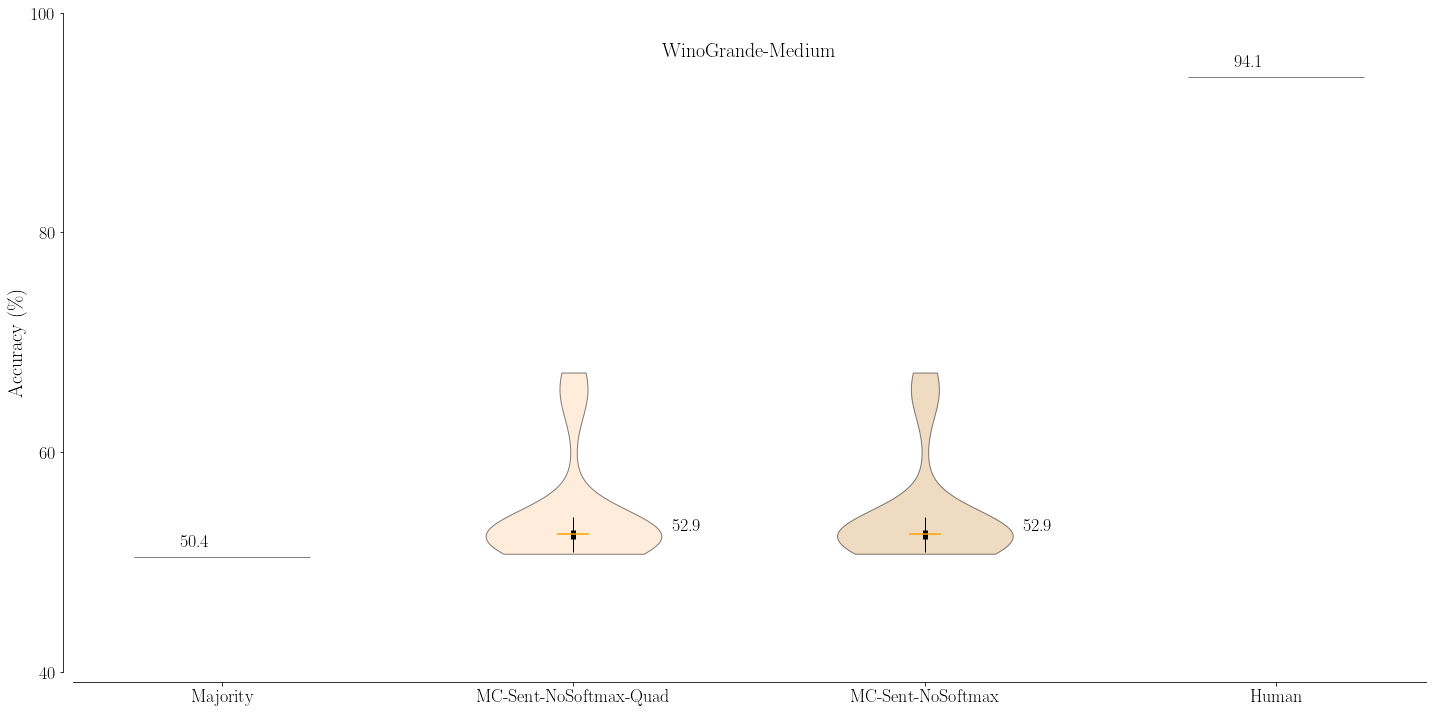

In [68]:
bar = False
box = False
violin = True

ordered_framings = [
    'MC-SENT-PAIR-QUAD',
    'MC-SENT-PAIR',
]

chart_labels = [
    'MC-Sent-NoSoftmax-Quad',
    'MC-Sent-NoSoftmax',
]

f_violin = make_box_plots(results4,
                   chart_labels,
                   ordered_framings,
                   adjusted_axes = True,
                   title = 'WinoGrande-Medium',
                   titleh=96,
                   showfliers = True,
                   x_size = 20,
                   y_size = 10,
                   y_min = 40,
                   y_max = 100,
                   y_tick = 20,
                   notch = False,
                   ylabel = r'Accuracy (\%)',
                   xlabel = None,
                   #xlabel = r'Formalization',
                   majority = 50.43,
                   human = 94.1,
                   label_size=20,
                   tick_size=18,
                   plabel_size=18,
                   x_offset = .88,
                   bar_colors = True,
                   bar_labels = True,
                   label_type = '3Q',
                   bar = bar,
                   box = box,
                   violin = violin,
                  )

In [70]:
ordered_framings4 = [
    'MC-SENT-PAIR-QUAD',
    'MC-SENT-PAIR',
]

stats4 = get_stats(results4,
                  ordered_framings4,
                 )

print(stats4)

{'MC-SENT-PAIR-QUAD': {'mean': 0.5443304393580637, 'std': 0.048827931156448914, 'medium': 0.5256511444356748, '1Q': 0.5209155485398579, '3Q': 0.5290055248618785, 'max': 0.6724546172059984, 'min': 0.5074980268350434, 'top_3Q_dist': 0.14344909234411996, 'kurtosis': 2.02902742211559}, 'MC-SENT-PAIR': {'mean': 0.5443304393580637, 'std': 0.048827931156448914, 'medium': 0.5256511444356748, '1Q': 0.5209155485398579, '3Q': 0.5290055248618785, 'max': 0.6724546172059984, 'min': 0.5074980268350434, 'top_3Q_dist': 0.14344909234411996, 'kurtosis': 2.02902742211559}}


In [72]:
# Perform Levene, Bartlett, and F test:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.levene.html#scipy.stats.levene
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bartlett.html
# https://stackoverflow.com/questions/21494141/how-do-i-do-a-f-test-in-python

mcsentpair = results4.loc[results4['framing']=='MC-SENT-PAIR']['best_val_accuracy']
mcsentpairquad = results4.loc[results4['framing']=='MC-SENT-PAIR-QUAD']['best_val_accuracy']

levene_stat, levene_p = levene(mcsentpair, mcsentpairquad)
bartlett_stat, bartlett_p = bartlett(mcsentpair, mcsentpairquad)
f_p = f.cdf(mcsentpairquad.var()/mcsentpair.var(),len(mcsentpairquad)-1,len(mcsentpair)-1)

print("Levene:")
print(f"Stat is: {levene_stat}")
print(f"P-value is: {levene_p}\n")

print("Bartlett:")
print(f"Stat is: {bartlett_stat}")
print(f"P-value is: {bartlett_p}\n")

print("F:")
print(f"P-value is: {f_p}\n")

Levene:
Stat is: 0.0
P-value is: 1.0

Bartlett:
Stat is: 0.0
P-value is: 1.0

F:
P-value is: 0.49999999999999994



# Save Stuff

In [ ]:
wd = os.path.dirname(os.path.abspath('__file__'))
now = dt.now().strftime("%Y%m%d_%H%M")

f = f_violin
f_type = 'violin'

plot_name = os.path.join(wd, 'plots', f"{DATASET}_plot_{f_type}_{now}.pdf")
stats_name = os.path.join(wd, 'stats', f"{DATASET}_stats_{now}.json")

f.savefig(plot_name)
with open(stats_name, 'w') as f:
    f.write(json.dumps(stats))